In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The GE dataset

In [2]:
df = pd.read_csv("data/Rune_Data.csv")

In [3]:
df.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1560038400000,5,5,5,5,4,4,213,209,99,202,119,365,147
1,1560124800000,5,5,5,5,4,4,213,209,99,202,122,364,147
2,1560211200000,5,5,5,5,4,4,213,211,99,203,127,360,147
3,1560297600000,5,5,5,5,4,4,211,212,99,203,125,357,147
4,1560384000000,5,5,5,5,4,4,207,213,99,203,119,353,147


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 120

In [6]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [7]:
uni_data = df['Chaos_rune']
uni_data.index = df['timestamp']
uni_data.head()

timestamp
1560038400000    99
1560124800000    99
1560211200000    99
1560297600000    99
1560384000000    99
Name: Chaos_rune, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002082F2E5E10>],
      dtype=object)

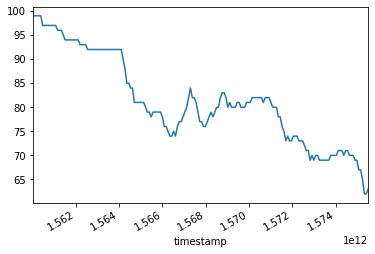

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [12]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[1.76042168]
 [1.76042168]
 [1.76042168]
 [1.76042168]
 [1.76042168]
 [1.49685262]
 [1.49685262]
 [1.49685262]
 [1.49685262]
 [1.49685262]]

 Target to predict
1.4968526184903184


In [14]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

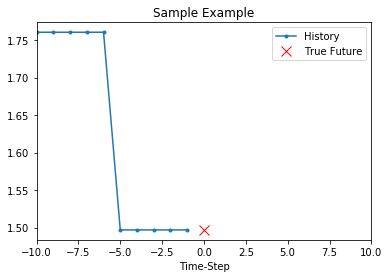

In [16]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

### Baseline


In [17]:
def baseline(history):
  return np.mean(history)

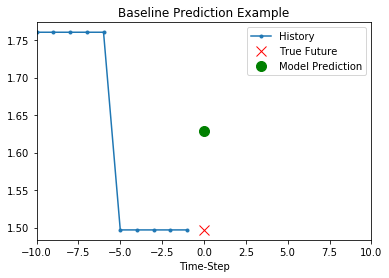

In [18]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [19]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(20, 1)


In [22]:
EVALUATION_INTERVAL = 500
EPOCHS = 15

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 8s 17ms/step - loss: 0.2710 - val_loss: 1.0685
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1567 - val_loss: 0.7484
Epoch 3/15
500/500 [==============================] - 3s 6ms/step - loss: 0.1149 - val_loss: 0.5184
Epoch 4/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0962 - val_loss: 0.3755
Epoch 5/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0821 - val_loss: 0.3416
Epoch 6/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0761 - val_loss: 0.3192
Epoch 7/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0740 - val_loss: 0.2835
Epoch 8/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0729 - val_loss: 0.2636
Epoch 9/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0719 - val_loss: 0.2429
Epoch 10/15
500/500 [==============================] - 3

#### Predict using the simple LSTM model


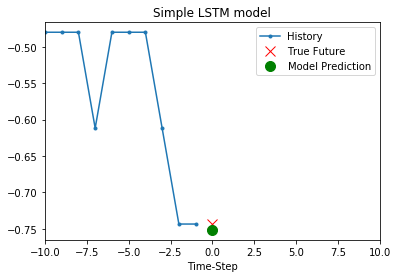

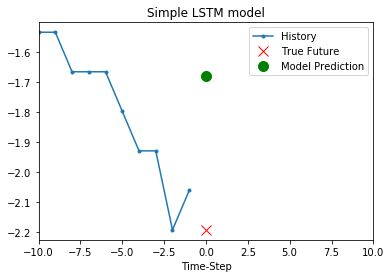

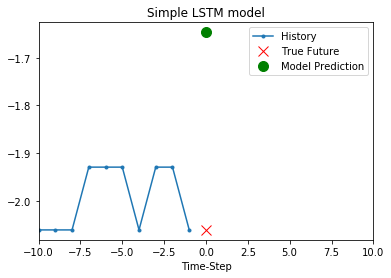

In [23]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Multivariate time series

In [24]:
features_considered = ['Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']

In [25]:
features = df[features_considered]
features.index = df['timestamp']
features.head()

,Nature_rune,Soul_rune,Blood_rune,Law_rune
timestamp,,,,
1560038400000,209,147,365,202
1560124800000,209,147,364,202
1560211200000,211,147,360,203
1560297600000,212,147,357,203
1560384000000,213,147,353,203


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020838FBCCF8>,
      dtype=object)

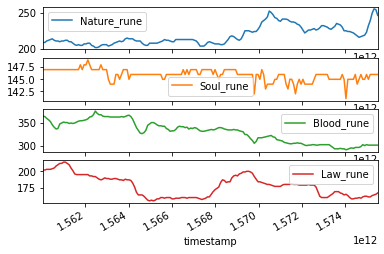

In [26]:
features.plot(subplots=True)

In [27]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [28]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [29]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [30]:
past_history = 10
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [31]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 4)


In [32]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [33]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [34]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(20, 1)


In [35]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 7s 15ms/step - loss: 0.5241 - val_loss: 0.7969
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.3525 - val_loss: 0.8322
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.3037 - val_loss: 0.8301
Epoch 4/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2562 - val_loss: 0.8538
Epoch 5/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2219 - val_loss: 0.7924
Epoch 6/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2045 - val_loss: 0.8580
Epoch 7/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1923 - val_loss: 0.8634
Epoch 8/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1807 - val_loss: 0.9157
Epoch 9/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1733 - val_loss: 0.9179
Epoch 10/15
500/500 [==============================] - 3

In [36]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

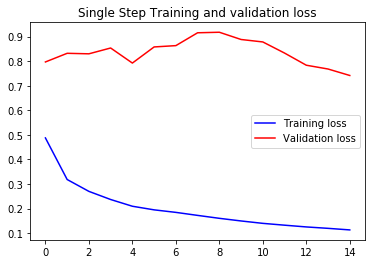

In [37]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

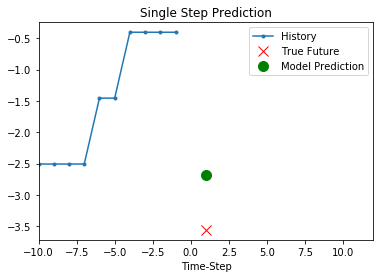

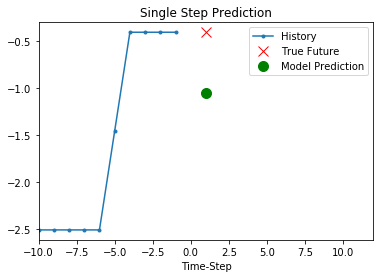

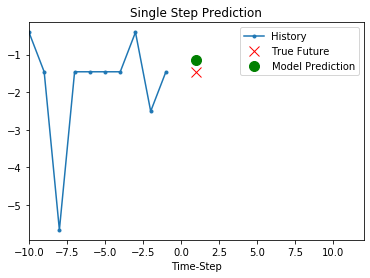

In [38]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [39]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [40]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 4)

 Target temperature to predict : (5,)


In [41]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [42]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

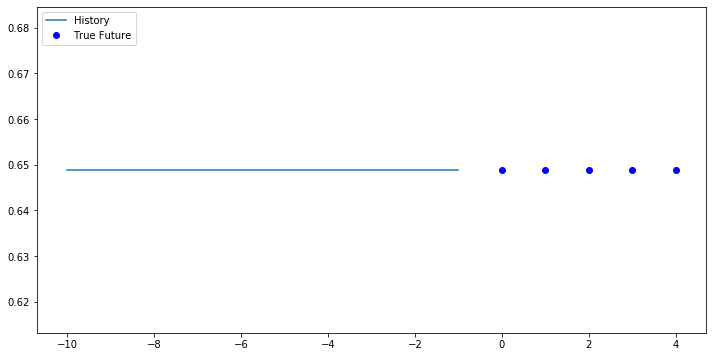

In [43]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [44]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [45]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(20, 5)


In [46]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 12s 25ms/step - loss: 0.6045 - val_loss: 1.9043
Epoch 2/15
500/500 [==============================] - 6s 12ms/step - loss: 0.4568 - val_loss: 2.2962
Epoch 3/15
500/500 [==============================] - 6s 11ms/step - loss: 0.3910 - val_loss: 1.8692
Epoch 4/15
500/500 [==============================] - 5s 11ms/step - loss: 0.3536 - val_loss: 1.6746
Epoch 5/15
500/500 [==============================] - 5s 11ms/step - loss: 0.3328 - val_loss: 1.5956
Epoch 6/15
500/500 [==============================] - 5s 11ms/step - loss: 0.3167 - val_loss: 1.5221
Epoch 7/15
500/500 [==============================] - 5s 11ms/step - loss: 0.3012 - val_loss: 1.6134
Epoch 8/15
500/500 [==============================] - 5s 11ms/step - loss: 0.2877 - val_loss: 1.5132
Epoch 9/15
500/500 [==============================] - 5s 11ms/step - loss: 0.2750 - val_loss: 1.5819
Epoch 10/15
500/500 [==========================

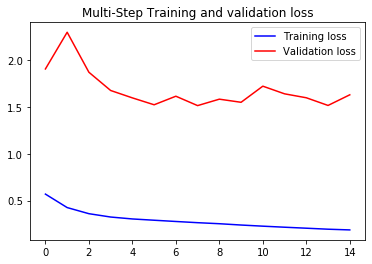

In [47]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

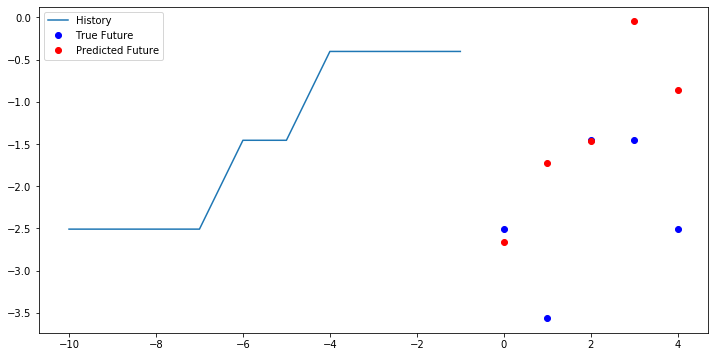

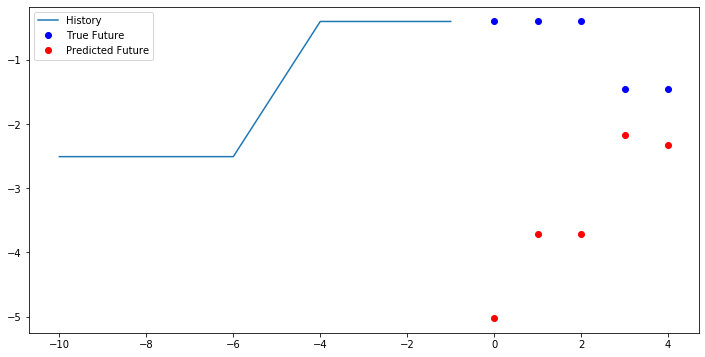

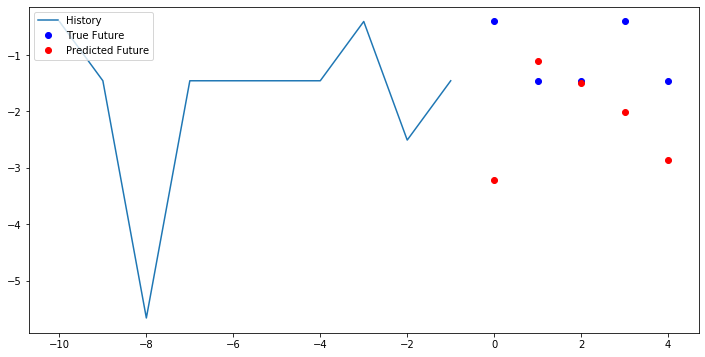

In [48]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])